# #Predict the price of the Uber ride from a given pickup point to the agreed drop-off location. Perform following tasks:
1.	Pre-process the dataset.
2.	Identify outliers.
3.	Check the correlation.
4.	Implement linear regression and random forest regression models.
5.	Evaluate the models and compare their respective scores like R2, RMSE, etc. Dataset link: https://www.kaggle.com/datasets/yasserh/uber-fares-dataset


In [1]:
#Importing the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#importing the dataset
df  = pd.read_csv("uber.csv")
df

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [8]:
df['dropoff_latitude'].fillna(value=df['dropoff_latitude'].mean(),inplace = True)
df['dropoff_longitude'].fillna(value=df['dropoff_longitude'].median(),inplace = True)

In [14]:
df.isnull().sum() 

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [15]:
df.dtypes

fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [18]:
#pip install haversine
import haversine as hs  #Calculate the distance using Haversine to calculate the distance between to points. Can't use Eucladian as it is for flat surface.
travel_dist = []
for pos in range(len(df['pickup_longitude'])):
        long1,lati1,long2,lati2 = [df['pickup_longitude'][pos],df['pickup_latitude'][pos],df['dropoff_longitude'][pos],df['dropoff_latitude'][pos]]
        loc1=(lati1,long1)
        loc2=(lati2,long2)
        c = hs.haversine(loc1,loc2)
        travel_dist.append(c)
    
print(travel_dist)
df['dist_travel_km'] = travel_dist
df.head()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek,dist_travel_km
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1.0,19,7,5,2015,3,1.683325
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1.0,20,17,7,2009,4,2.457593
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1.0,21,24,8,2009,0,5.036384
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3.0,8,26,6,2009,4,1.661686
4,16.0,2014-08-28 17:47:00+00:00,-73.929786,40.744085,-73.973082,40.761247,3.5,17,28,8,2014,3,4.116088


In [19]:
#Uber doesn't travel over 130 kms so minimize the distance 
df= df.loc[(df.dist_travel_km >= 1) | (df.dist_travel_km <= 130)]
print("Remaining observastions in the dataset:", df.shape)

Remaining observastions in the dataset: (200000, 13)


In [20]:
#Finding inccorect latitude (Less than or greater than 90) and longitude (greater than or less than 180)
incorrect_coordinates = df.loc[(df.pickup_latitude > 90) |(df.pickup_latitude < -90) |
                                   (df.dropoff_latitude > 90) |(df.dropoff_latitude < -90) |
                                   (df.pickup_longitude > 180) |(df.pickup_longitude < -180) |
                                   (df.dropoff_longitude > 90) |(df.dropoff_longitude < -90)
                                    ]

In [21]:
df.drop(incorrect_coordinates, inplace = True, errors = 'ignore')

In [22]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek,dist_travel_km
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1.0,19,7,5,2015,3,1.683325
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1.0,20,17,7,2009,4,2.457593
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1.0,21,24,8,2009,0,5.036384
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3.0,8,26,6,2009,4,1.661686
4,16.0,2014-08-28 17:47:00+00:00,-73.929786,40.744085,-73.973082,40.761247,3.5,17,28,8,2014,3,4.116088


In [32]:
df.isnull().sum()

fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
hour                 0
day                  0
month                0
year                 0
dayofweek            0
dist_travel_km       0
dtype: int64

In [24]:
corr = df.corr() #Function to find the correlation

In [25]:
corr

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek,dist_travel_km
fare_amount,1.000000,0.154069,-0.110842,0.218675,-0.125898,0.015778,-0.023623,0.004534,0.030817,0.141277,0.013652,0.786385
pickup_longitude,0.154069,1.000000,0.259497,0.425619,0.073290,-0.013213,0.011579,-0.003204,0.001169,0.010198,-0.024652,0.048446
pickup_latitude,-0.110842,0.259497,1.000000,0.048889,0.515714,-0.012889,0.029681,-0.001553,0.001562,-0.014243,-0.042310,-0.073362
dropoff_longitude,0.218675,0.425619,0.048889,1.000000,0.245667,-0.009303,-0.046558,-0.004007,0.002391,0.011346,-0.003336,0.155191
dropoff_latitude,-0.125898,0.073290,0.515714,0.245667,1.000000,-0.006308,0.019783,-0.003479,-0.001193,-0.009603,-0.031919,-0.052701
passenger_count,0.015778,-0.013213,-0.012889,-0.009303,-0.006308,1.000000,0.020274,0.002712,0.010351,-0.009749,0.048550,0.009884
hour,-0.023623,0.011579,0.029681,-0.046558,0.019783,0.020274,1.000000,0.004677,-0.003926,0.002156,-0.086947,-0.035708
day,0.004534,-0.003204,-0.001553,-0.004007,-0.003479,0.002712,0.004677,1.000000,-0.017360,-0.012170,0.005617,0.001709
month,0.030817,0.001169,0.001562,0.002391,-0.001193,0.010351,-0.003926,-0.017360,1.000000,-0.115859,-0.008786,0.010050
year,0.141277,0.010198,-0.014243,0.011346,-0.009603,-0.009749,0.002156,-0.012170,-0.115859,1.000000,0.006113,0.022294


<AxesSubplot: >

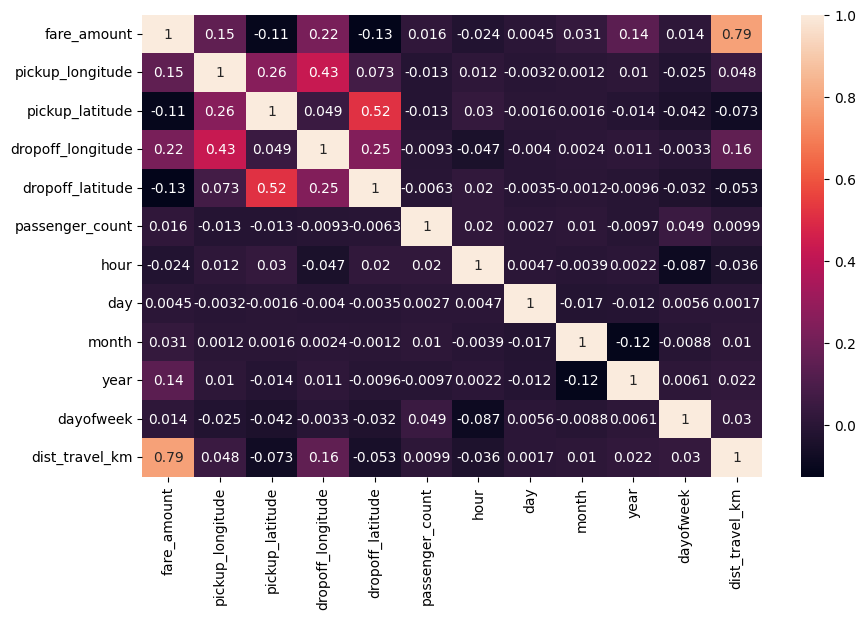

In [26]:
fig,axis = plt.subplots(figsize = (10,6))
sns.heatmap(df.corr(),annot = True) #Correlation Heatmap (Light values means highly correlated)

### Dividing the dataset into feature and target values 

In [27]:
x = df[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','hour','day','month','year','dayofweek','dist_travel_km']]

In [28]:
y = df['fare_amount']

### Dividing the dataset into training and testing dataset

In [29]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.33)

### Linear Regression

In [30]:
from sklearn.linear_model import LinearRegression
regression = LinearRegression()

In [31]:
regression.fit(X_train,y_train)

LinearRegression()

In [34]:
prediction = regression.predict(X_test) #To predict the target values

In [35]:
print(prediction)

[ 4.16001291 13.46201175 13.97432013 ... 15.49066182  4.78559905
  9.07468029]


In [36]:
y_test

13571      2.90
165829    13.70
100518    15.50
122241    22.25
118494    22.25
          ...  
49253     15.50
31026      6.10
146662    18.00
82639      4.10
145226     8.10
Name: fare_amount, Length: 66000, dtype: float64

### Metrics Evaluation using R2, Mean Squared Error, Root Mean Sqared Error

In [37]:
from sklearn.metrics import r2_score 

In [38]:
r2_score(y_test,prediction)

0.659916544468119

In [39]:
from sklearn.metrics import mean_squared_error

In [40]:
MSE = mean_squared_error(y_test,prediction)

In [41]:
MSE 

10.08767355249308

In [42]:
RMSE = np.sqrt(MSE)

In [43]:
RMSE

3.1761098143000472

### Random Forest Regression

In [44]:
from sklearn.ensemble import RandomForestRegressor

In [45]:
rf = RandomForestRegressor(n_estimators=100) #Here n_estimators means number of trees you want to build before making the prediction

In [ ]:
rf.fit(X_train,y_train)

In [201]:
y_pred = rf.predict(X_test)

In [202]:
y_pred

array([ 5.714 , 10.285 , 12.68  , ...,  6.338 , 19.4685,  7.712 ])

### Metrics evaluatin for Random Forest

In [210]:
R2_Random = r2_score(y_test,y_pred)

In [211]:
R2_Random

0.7948374920410631

In [205]:
MSE_Random = mean_squared_error(y_test,y_pred)

In [206]:
MSE_Random

6.104112397417331

In [207]:
RMSE_Random = np.sqrt(MSE_Random)

In [208]:
RMSE_Random

2.4706501972997574